In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
import random

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/arabic-names/all_arabic_names.txt


## Preparing Data

In [2]:
words = open('../input/arabic-names/all_arabic_names.txt', 'r').read().splitlines()
len(words)

10692

In [9]:
# Tokenise characters by assigning them numerical value
# '.' is special value to indicate beginning/end of name

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
itos

{1: ' ',
 2: ',',
 3: 'ء',
 4: 'آ',
 5: 'أ',
 6: 'ؤ',
 7: 'إ',
 8: 'ئ',
 9: 'ا',
 10: 'ب',
 11: 'ة',
 12: 'ت',
 13: 'ث',
 14: 'ج',
 15: 'ح',
 16: 'خ',
 17: 'د',
 18: 'ذ',
 19: 'ر',
 20: 'ز',
 21: 'س',
 22: 'ش',
 23: 'ص',
 24: 'ض',
 25: 'ط',
 26: 'ظ',
 27: 'ع',
 28: 'غ',
 29: 'ف',
 30: 'ق',
 31: 'ك',
 32: 'ل',
 33: 'م',
 34: 'ن',
 35: 'ه',
 36: 'و',
 37: 'ى',
 38: 'ي',
 39: 'ً',
 40: 'ٌ',
 41: 'ٍ',
 42: 'َ',
 43: 'ُ',
 44: 'ِ',
 45: 'ّ',
 46: 'ْ',
 47: 'ٰ',
 0: '.'}

In [4]:
# train/val/dev split = 80/10/10

block_size = 3

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
    #         print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

In [5]:
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_tr, Y_tr = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_val, Y_val = build_dataset(words[n2:])

torch.Size([51348, 3]) torch.Size([51348])
torch.Size([6437, 3]) torch.Size([6437])
torch.Size([6405, 3]) torch.Size([6405])


tensor(0.0015) tensor(0.9980)
tensor(-0.0006) tensor(1.0106)


(array([2.34780781e-05, 7.04342344e-05, 9.39123125e-05, 1.64346547e-04,
        2.34780781e-04, 2.81736937e-04, 4.69561562e-04, 1.10346967e-03,
        1.64346547e-03, 3.09910631e-03, 4.55474716e-03, 6.94951112e-03,
        1.10346967e-02, 1.76320367e-02, 2.56380613e-02, 3.89031755e-02,
        5.89769322e-02, 8.21263173e-02, 1.13939113e-01, 1.58077900e-01,
        1.99164537e-01, 2.56239745e-01, 3.21180109e-01, 3.75625772e-01,
        4.10208981e-01, 4.26291465e-01, 4.20257598e-01, 3.87036118e-01,
        3.26908760e-01, 2.67368354e-01, 2.16092231e-01, 1.67610000e-01,
        1.21499054e-01, 8.97801707e-02, 6.09490908e-02, 4.26596680e-02,
        2.93006415e-02, 1.86885502e-02, 1.26781622e-02, 8.31123966e-03,
        5.16517719e-03, 2.98171592e-03, 2.01911472e-03, 1.10346967e-03,
        6.80864266e-04, 3.75649250e-04, 1.40868469e-04, 1.17390391e-04,
        9.39123125e-05, 7.04342344e-05]),
 array([-5.45457411, -5.24160949, -5.02864487, -4.81568025, -4.60271563,
        -4.38975101, 

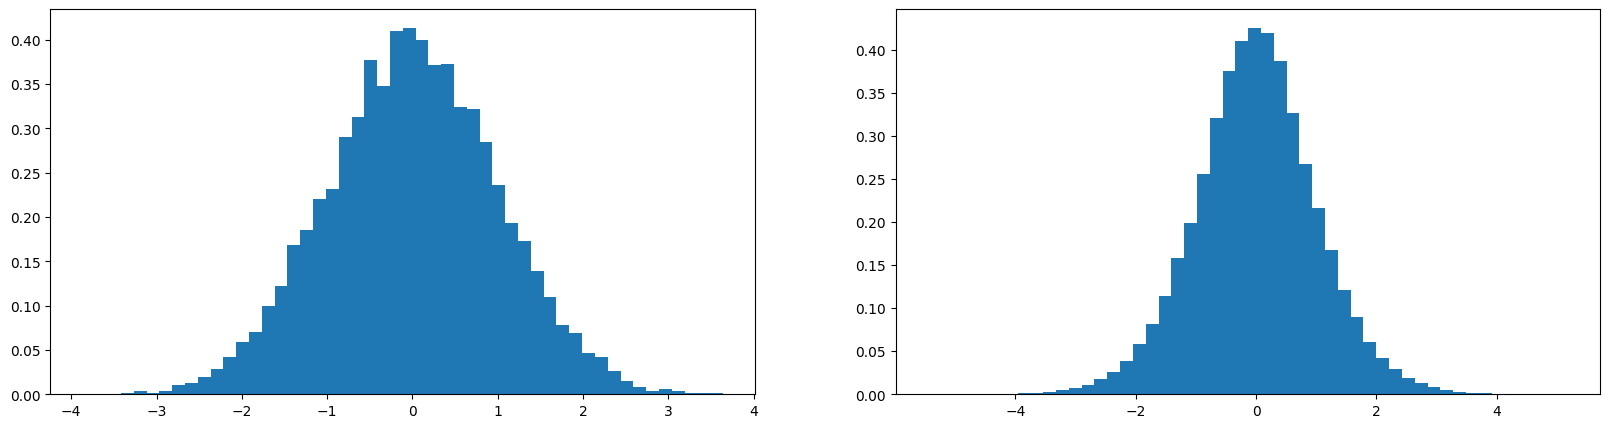

In [6]:
'''
trying to find initial value for scale to multiply weights by
we want distributions of x and y to be around the same
the usual value is to divide the weight by the square root of the fan in (number of input neurons)
'''

x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

## Neural Network

In [23]:
# full neural network, writing out layers from scratch instead of using pytorch layers

'''
linear layer, corresponds to the old code:

h = emb_cat @ W1

'''
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # Kaiming init
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def params(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
'''
batch normalization layer, corresponds to the old code:

bn_mean = h.mean(0, keepdim=True)
bn_std = h.std(0, keepdim=True)
h = bn_gain * (h - bn_mean)/bn_std + bn_bias
with torch.no_grad():
    bn_mean_running = 0.999 * bn_mean_running + 0.001 * bn_mean
    bn_std_running = 0.999 * bn_std_running + 0.001 * bn_std
'''

class BatchNorm:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
#         calculate forward pass
        if self.training:
            x_mean = x.mean(0, keepdim=True)
            x_var = x.var(0, keepdim=True)
        else:
            x_mean = self.running_mean
            x_var = self.running_var
        x_hat = (x - x_mean) / torch.sqrt(x_var + self.eps)
        self.out = self.gamma * x_hat + self.beta
        
#         update buffers
        if self.training:
            '''
            if we don't use torch.no_grad() pytorch will build a computational graph containing 
            all previous values of this variable in order to calculate backprop, do not forget this declaration when 
            working with tensors that you will not calculate backprop on
            '''
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var
        return self.out
    
    def params(self):
        return [self.gamma, self.beta]
    
'''
tanh activation function, corresponds to old code:

h_act = torch.tanh(h)
'''

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def params(self):
        return []

In [66]:
# create network here

n_embd = 10 # dimensions of vector embedding for characters
n_hidden = 96 
gain = 5/3 # value to renormalise distribution after applying activation function - different for each activation function

C = torch.randn((vocab_size, n_embd))

layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias=False), BatchNorm(vocab_size),
]

with torch.no_grad():
#     make last layer less confident
    layers[-1].gamma *= 0.1
#     apply gain to other layers
    for l in layers[:-1]:
        if isinstance(l, Linear):
            l.weight *= gain

params = [C] + [p for l in layers for p in l.params()]
print(sum(p.nelement() for p in params))
for p in params:
    p.requires_grad = True

36480


## Training

In [67]:
losses = []
steps = []

In [68]:
max_steps = 50000
batch_size = 64
ud = []

for i in range(max_steps):
    # mini-batching
    ix = torch.randint(0, X_tr.shape[0], (batch_size,))
    X_b, Y_b = X_tr[ix], Y_tr[ix]
    
    # forward pass
    emb = C[X_b]
    x = emb.view(emb.shape[0], -1) # concat the vectors
    
    for l in layers:
        x = l(x)
    
    loss = F.cross_entropy(x, Y_b)
    
    if (i % 1000 == 0):
        print(f"{i}/{max_steps}: {loss.item()}")
    
    # backward pass
    for l in layers:
        l.out.retain_grad()
    for p in params:
        p.grad = None
    
    loss.backward()
    
#     update
    lr = 0.1 if i < max_steps/2 else 0.01

    for p in params:
        p.data += -lr * p.grad
        
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in params])
        
#     track stats
    losses.append(loss.log10().item()) #  just plotting loss can give graph hockey stick appearance, log squashes it
    steps.append(i)

0/50000: 3.842456817626953
1000/50000: 3.1202783584594727
2000/50000: 2.665449619293213
3000/50000: 2.658935070037842
4000/50000: 2.7131659984588623
5000/50000: 2.4047505855560303
6000/50000: 2.7177016735076904
7000/50000: 2.520394802093506
8000/50000: 2.388880968093872
9000/50000: 2.1246743202209473
10000/50000: 2.3376729488372803
11000/50000: 2.2602522373199463
12000/50000: 2.431035280227661
13000/50000: 2.1529741287231445
14000/50000: 2.0109260082244873
15000/50000: 2.2628204822540283
16000/50000: 2.2353806495666504
17000/50000: 2.365666627883911
18000/50000: 2.2632548809051514
19000/50000: 2.1110293865203857
20000/50000: 2.3492209911346436
21000/50000: 2.136000871658325
22000/50000: 2.428330659866333
23000/50000: 2.3651981353759766
24000/50000: 1.9940276145935059
25000/50000: 2.0817642211914062
26000/50000: 2.1180009841918945
27000/50000: 2.2938249111175537
28000/50000: 2.010380268096924
29000/50000: 2.365407943725586
30000/50000: 2.121096134185791
31000/50000: 2.065614938735962
32

## Diagnostic Tools

layer 2 (Tanh): mean 0.014658172614872456, std: 0.6681814193725586, saturated: 10.009765625%
layer 5 (Tanh): mean 0.015863152220845222, std: 0.702396810054779, saturated: 12.939453125%
layer 8 (Tanh): mean 0.007248788606375456, std: 0.7227206826210022, saturated: 12.141927719116211%
layer 11 (Tanh): mean -0.00032601505517959595, std: 0.7601922750473022, saturated: 12.565104484558105%


Text(0.5, 1.0, 'activation distribution')

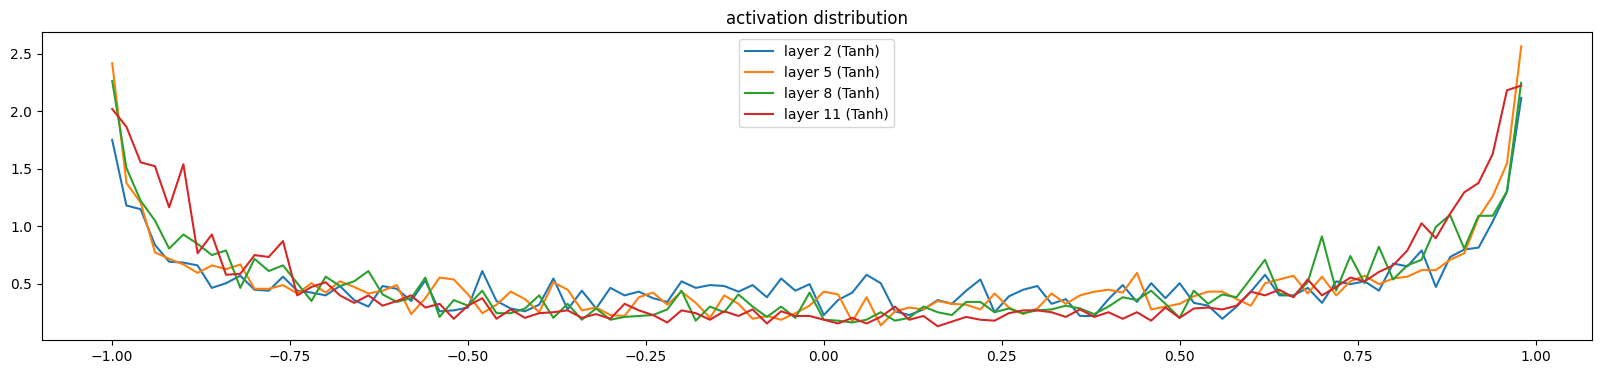

In [69]:
'''
visualise activations
want mean around 0 and std around 1
dont want saturation to be too high (measures proportion of values at tail ends of tanh activation) - below 10% is good
'''

plt.figure(figsize=(20,4))
legends = []
for i, l in enumerate (layers[:-1]): # excluding output layer
    if isinstance(l, Tanh):
        t = l.out
        name = l.__class__.__name__
        print(f"layer {i} ({name}): mean {t.mean()}, std: {t.std()}, saturated: {(t.abs() > 0.97).float().mean()*100}%")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({name})")
plt.legend(legends)
plt.title("activation distribution")

layer 2 (Tanh): mean -1.6086687537608668e-11, std: 0.0038044496905058622, saturated: 0.0%
layer 5 (Tanh): mean -4.784321268151703e-13, std: 0.003569922409951687, saturated: 0.0%
layer 8 (Tanh): mean 2.690588420464768e-12, std: 0.0033868043683469296, saturated: 0.0%
layer 11 (Tanh): mean 5.5990767577895895e-12, std: 0.00334092671982944, saturated: 0.0%


Text(0.5, 1.0, 'gradient distribution')

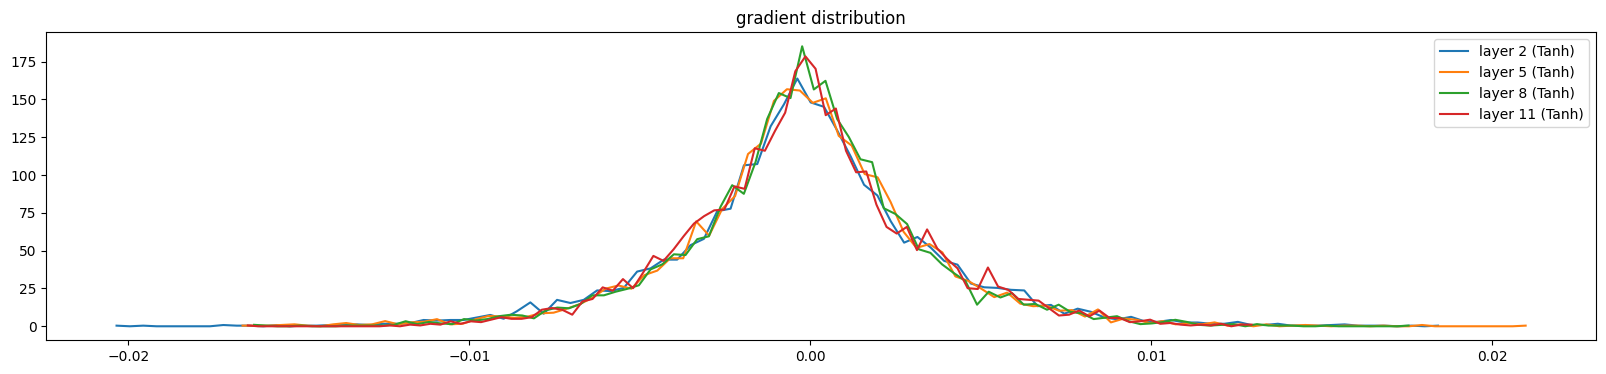

In [70]:
'''
visualise backward pass
should resemble gaussian distribution
we want gradients of each layer to be similar, no outliers growing or shrinking
'''
plt.figure(figsize=(20,4))
legends = []
for i, l in enumerate (layers[:-1]): # excluding output layer
    if isinstance(l, Tanh):
        t = l.out.grad
        name = l.__class__.__name__
        print(f"layer {i} ({name}): mean {t.mean()}, std: {t.std()}, saturated: {(t.abs() > 0.97).float().mean()*100}%")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({name})")
plt.legend(legends)
plt.title("gradient distribution")

weight (64, 48) | mean -5.381176840929536e-12 | std 0.0019839247688651085 | grad:data ratio 0.001957974163815379
weight (64, 48) | mean -5.381176840929536e-12 | std 0.0019839247688651085 | grad:data ratio 0.005851385183632374
weight (64, 48) | mean -5.381176840929536e-12 | std 0.0019839247688651085 | grad:data ratio 0.009702872484922409
weight (64, 48) | mean -5.381176840929536e-12 | std 0.0019839247688651085 | grad:data ratio 0.00976536050438881
weight (64, 48) | mean -5.381176840929536e-12 | std 0.0019839247688651085 | grad:data ratio 0.009919005446135998
weight (64, 48) | mean -5.381176840929536e-12 | std 0.0019839247688651085 | grad:data ratio 0.0092670489102602


Text(0.5, 1.0, 'weights gradient distribution')

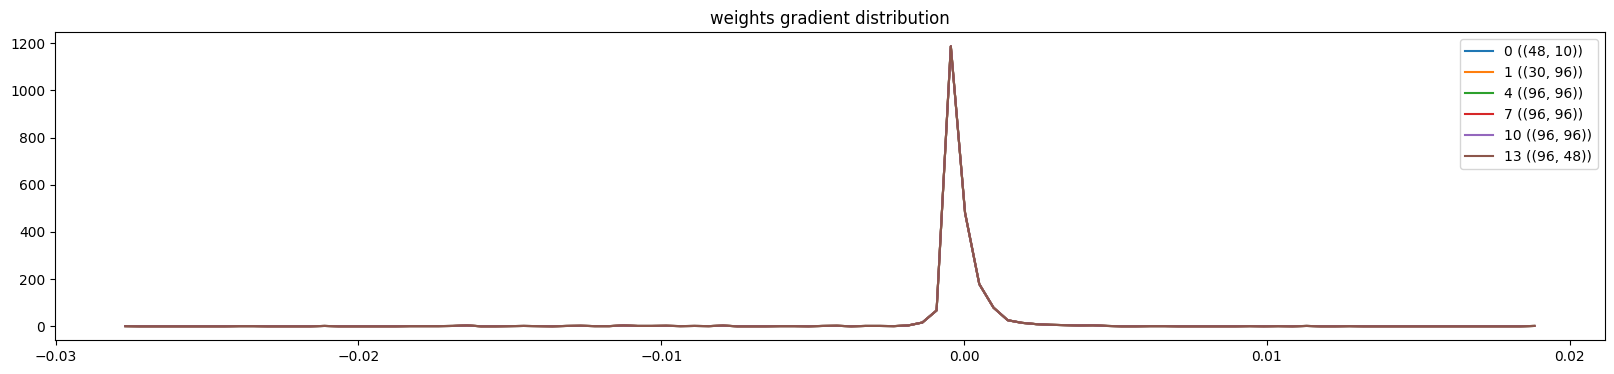

In [71]:
'''
visualise parameters
'''

plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate (params): # excluding output layer
    t = p.grad
    if p.ndim == 2: # constrain just to weights
        t = l.out.grad
        print(f"weight {tuple(t.shape)} | mean {t.mean()} | std {t.std()} | grad:data ratio {t.std() / p.std()}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} ({tuple(p.shape)})")
plt.legend(legends)
plt.title("weights gradient distribution")

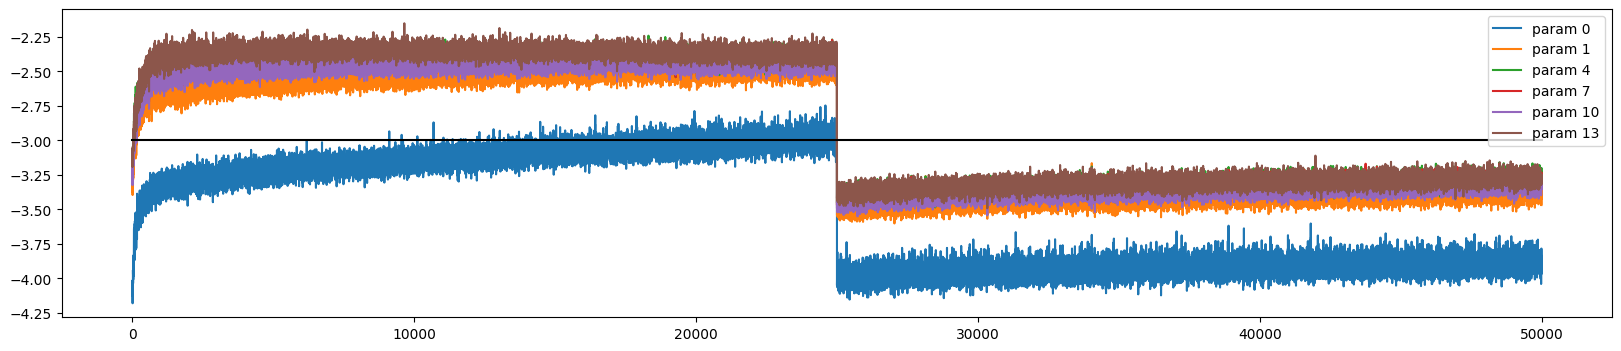

In [72]:
'''
visualise learning rate update rate

should initially increase then stabilise with layers not too far from each other
we want it to be around -3
too low and the network is not learning fast enough, too high and its unstable
'''

plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate (params): # excluding output layer
    if p.ndim == 2: # constrain just to weights
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f"param {i}")
plt.plot([0, len(ud)], [-3, -3], 'k') # ratios should be ~1e-3, indicate on plot
plt.legend(legends)

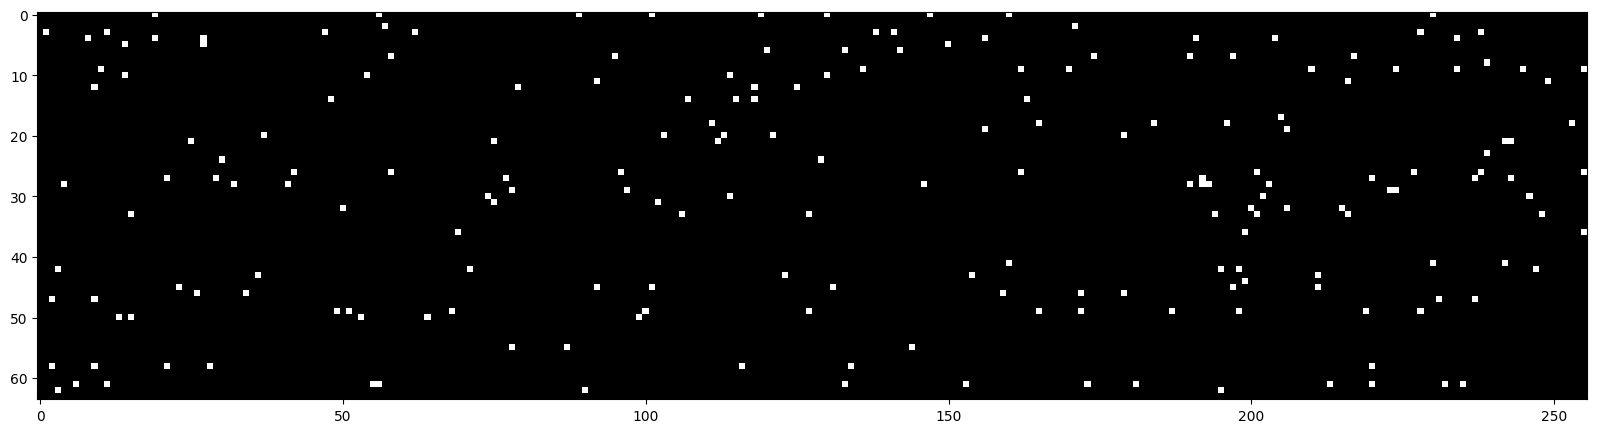

In [36]:
'''
WARNING: uses old code, do not rerun this cell

display activations of neurons - black if -1 < activation < 1 
look for columns of complete white here - this signifies a 'dead neuron' 
which is not learning since all examples land in tail  of activation function instead 
of middle 'active' part of tanh activation function
''' 

plt.figure(figsize=(20,10))
plt.imshow(h_act.abs() > 0.99, cmap='gray', interpolation='nearest')

## Evaluation

In [73]:
@torch.no_grad() # disable gradient tracking
def split_loss(split):
    x, y = {
        'train': (X_tr, Y_tr),
        'val': (X_val, Y_val),
        'dev': (X_dev, Y_dev),
    } [split]
    
    emb = C[x]
    x = emb.view(emb.shape[0], emb.shape[1] * emb.shape[2])
    for l in layers:
        x = l(x)
    loss = F.cross_entropy(x, y)
    
    
    print(f"{split}: {loss.item()}")

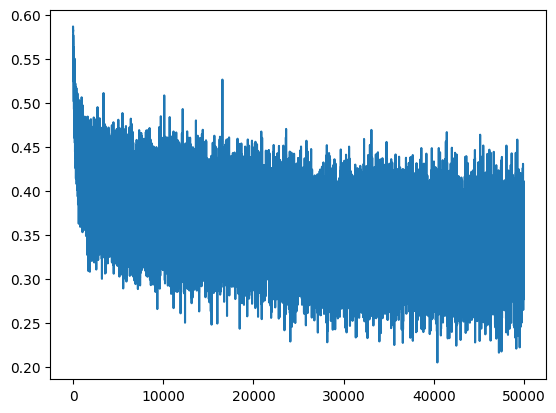

In [74]:
plt.plot(losses)

In [75]:
# put layers into eval mode
for l in layers:
    l.training = False

split_loss('train')
split_loss('val')

train: 2.130577325820923
val: 2.476191759109497


In [76]:
split_loss('dev')

dev: 2.4427738189697266


## Generate Names

In [77]:
# sample from the model
g = torch.Generator()

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialise with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        x = emb.view(emb.shape[0], -1)
        for l in layers:
            x = l(x)
        logits = x
        probs = F.softmax(logits, dim=1)
#         sample from distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
#         break when we reach '.'
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

مرزاق.
أمان.
إليا.
قتعادل.
شهال.
مزدالصالحميده.
أول.
رف الرزيم.
فريد.
سوم.
ٍمان.
عزوزه.
فريفاء.
ووان.
ميلانيس.
لام.
  ارس.
سلوم.
بندا.
رشا.
